**Tarun Neelesh   : 23M0029**\
**Anirudha Shinde : 22B2181**


**link to the voice_over video** : [Voice over video](https://drive.google.com/file/d/1flE2BtsUdHI4BYRH_-jaTN3Ms089do9R/view?usp=drive_link)

**The code should be runned after downloading data** : \
**1) link to the data file** : [Data file](https://drive.google.com/file/d/1oM0TXl4uRWIjKd9akGtTwfNWKpzjsgAc/view?usp=drive_link)


In [1]:
# Tarun Neelesh   : 23M0029
# Anirudha Shinde : 22B2181 

# link to the voice_over video : "https://drive.google.com/file/d/1flE2BtsUdHI4BYRH_-jaTN3Ms089do9R/view?usp=drive_link"

# The code should be runned after downloading data : 
# 1) link to the data file : "https://drive.google.com/file/d/1oM0TXl4uRWIjKd9akGtTwfNWKpzjsgAc/view?usp=drive_link"
# 2) link to data file is also given on moodle


%matplotlib inline 
# This is a magic command in Jupyter Notebooks and other similar environments
# that allows for inline plotting,
# meaning that plots will appear directly in the notebook output

import tensorflow as tf # A popular machine learning library.
from math import pi # The mathematical constant π (pi).
import gdown # A library for downloading files from Google Drive.

import keras # A high-level neural networks API running on top of TensorFlow.
from keras import backend as K 
from keras.layers import Dense
from keras.models import Sequential, Model
from keras import regularizers  # Import regularizers module

import matplotlib.pyplot as plt # # A plotting library for Python.
import numpy as np # # A library for numerical computing.
import os.path  # A module for common path manipulations.
from scipy.io import loadmat  # A function for loading MATLAB data files.

# Define PReLU activation function
# Parametric Rectified Linear Unit (PReLU) activation function
class PReLU(tf.keras.layers.Layer):
    def __init__(self, alpha_initializer='zeros', **kwargs):
        super(PReLU, self).__init__(**kwargs)
        self.alpha_initializer = tf.keras.initializers.get(alpha_initializer)

    def build(self, input_shape):
        self.alpha = self.add_weight(shape=(input_shape[-1],),
                                      initializer=self.alpha_initializer,
                                      name='alpha',
                                      trainable=True)
        super(PReLU, self).build(input_shape)

    def call(self, inputs):
        pos = tf.nn.relu(inputs) # This line computes the positive part of the input using the ReLU activation function.
        neg = -self.alpha * tf.nn.relu(-inputs) # This line computes the negative part of the input using the
        # ReLU activation function but with negative inputs.
        # It multiplies the negative part by the learnable parameter alpha.
        return pos + neg # This line returns the sum of the positive and negative parts, effectively implementing the PReLU activation function.

output_q = 'eq' #output_q can take the following values -- 'decay', 'eq', 'power'
train_x = loadmat('All_Data.mat')['input_data_train']
test_x = loadmat('All_Data.mat')['input_data_test']
train_y = np.squeeze(loadmat('All_Data.mat')[output_q + '_train']) #  The np.squeeze function is used to remove any singleton
test_y = np.squeeze(loadmat('All_Data.mat')[output_q + '_test']) # dimensions, resulting in a 1D array if applicable.

# Do minmax scaling to rescale them to the range [-1, 1].
min_x = train_x.min(0)
max_x = train_x.max(0)
train_x = 2*(train_x - min_x)/(max_x - min_x) - 1
test_x = 2*(test_x - min_x)/(max_x - min_x) - 1

# Do minmax scaling to rescale them to the range [-1, 1].
min_decaytime = train_y.min(0)
max_decaytime = train_y.max(0)
train_y = 2*(train_y - min_decaytime)/(max_decaytime - min_decaytime) - 1
test_y = 2*(test_y - min_decaytime)/(max_decaytime - min_decaytime) - 1

# NN options
n_ensemble = 10 # TUNE! no. NNs in ensemble
reg = 'anc'      # type of regularisation to use - anc (anchoring) reg (regularised) free (unconstrained)
n_hidden = 25    # TUNE! no. hidden units in NN
activation_in = 'relu' # tanh relu sigmoid
data_noise = (0.03/((max_decaytime - min_decaytime)/2))**2 # TUNE! estimated noise variance

n_data = train_x.shape[0]
print(n_data)
n_dim = train_x.shape[-1]
print(n_dim)

# Variance of priors
# Setting appropriate variances for the prior distributions is essential in Bayesian neural networks,
# where priors represent our beliefs about the parameters before observing the data. These values are often fine-tuned
# during the model development process to achieve better performance or match the characteristics of the dataset.
W1_var = 1.0/n_dim        # TUNE! 1st layer weights and biases
W_mid_var = 1.0/n_hidden  # 2nd layer weights and biases
W_last_var = 1.0/n_hidden # 3rd layer weights

# NN object
def fn_make_NN(reg='anc', activation_in='relu'):
    # get initialisations, and regularisation values
    
    # These lines compute the regularization values and initialize the weights for the first layer of the neural network.
    W1_lambda = data_noise/W1_var # calculates the regularization based on the data noise and the variance of weights for the first layer.
    W1_anc = np.random.normal(loc=0, scale=np.sqrt(W1_var), size=[n_dim, n_hidden]) #  initializes the weights for the first layer with a normal distribution.
    W1_init = np.random.normal(loc=0, scale=np.sqrt(W1_var), size=[n_dim, n_hidden]) # initializes the weights for the first layer with the normal distribution.

    b1_var = W1_var * n_dim
    b1_lambda =  data_noise / b1_var
    b1_anc = np.random.normal(loc=0, scale=np.sqrt(b1_var), size=[n_hidden])
    b1_init = np.random.normal(loc=0, scale=np.sqrt(b1_var), size=[n_hidden])

    W_mid_lambda = data_noise / W_mid_var
    W_mid_anc = np.random.normal(loc=0, scale=np.sqrt(W_mid_var), size=[n_hidden, n_hidden])
    W_mid_init = np.random.normal(loc=0, scale=np.sqrt(W_mid_var), size=[n_hidden, n_hidden])

    b_mid_var = W_mid_var
    b_mid_lambda =  data_noise / b_mid_var
    b_mid_anc = np.random.normal(loc=0, scale=np.sqrt(b_mid_var), size=[n_hidden])
    b_mid_init = np.random.normal(loc=0, scale=np.sqrt(b_mid_var), size=[n_hidden])

    W_last_lambda = data_noise / W_last_var
    W_last_anc = np.random.normal(loc=0, scale=np.sqrt(W_last_var), size=[n_hidden, 1])
    W_last_init = np.random.normal(loc=0, scale=np.sqrt(W_last_var), size=[n_hidden, 1])

    def custom_reg_W1(W1_lambda, n_data):
        if reg == 'reg':
            return regularizers.l2(W1_lambda / n_data)
        elif reg == 'free':
            return None
        elif reg == 'anc':
            return regularizers.l2(W1_lambda / n_data)

    def custom_reg_b1(b1_lambda, n_data):
        if reg == 'reg':
            return regularizers.l2(b1_lambda / n_data)
        elif reg == 'free':
            return None
        elif reg == 'anc':
            return regularizers.l2(b1_lambda / n_data)

    def custom_reg_W_mid(W_mid_lambda, n_data):
        if reg == 'reg':
            return regularizers.l2(W_mid_lambda / n_data)
        elif reg == 'free':
            return None
        elif reg == 'anc':
            return regularizers.l2(W_mid_lambda / n_data)

    def custom_reg_b_mid(b_mid_lambda, n_data):
        if reg == 'reg':
            return regularizers.l2(b_mid_lambda / n_data)
        elif reg == 'free':
            return None
        elif reg == 'anc':
            return regularizers.l2(b_mid_lambda / n_data)

    def custom_reg_W_last(W_last_lambda, n_data):
        if reg == 'reg':
            return regularizers.l2(W_last_lambda / n_data)
        elif reg == 'free':
            return None
        elif reg == 'anc':
            return regularizers.l2(W_last_lambda / n_data)

    model = Sequential()  # Initialize the model

    # Modify your model creation to pass the required parameters
    
    # This adds the first dense layer to the model, including the input shape, activation function,
    # initializers, and regularizers based on the settings and regularization techniques defined above.
    model.add(Dense(n_hidden, activation=activation_in, input_shape=(n_dim,),
                    kernel_initializer=keras.initializers.Constant(value=W1_init),
                    bias_initializer=keras.initializers.Constant(value=b1_init),
                    kernel_regularizer=custom_reg_W1(W1_lambda, n_data),
                    bias_regularizer=custom_reg_b1(b1_lambda, n_data)))

    # This adds the second dense layer to the model with similar configurations.
    model.add(Dense(n_hidden, activation=activation_in,
                    kernel_initializer=keras.initializers.Constant(value=W_mid_init),
                    bias_initializer=keras.initializers.Constant(value=b_mid_init),
                    kernel_regularizer=custom_reg_W_mid(W_mid_lambda, n_data),
                    bias_regularizer=custom_reg_b_mid(b_mid_lambda, n_data)))

    # This adds the final dense layer to the model with linear activation function (useful for regression tasks) and no bias
    model.add(Dense(1, activation='linear', use_bias=False,
                    kernel_initializer=keras.initializers.Constant(value=W_last_init),
                    kernel_regularizer=custom_reg_W_last(W_last_lambda, n_data)))

    return model


# Finally, the function returns three values:
# y_preds: The predictions from each individual model, organized as a NumPy array.
# y_preds_mu: The mean prediction across all models.
# y_preds_std: The standard deviation of predictions across all models, providing an estimate of uncertainty.
def fn_predict_ensemble(NNs, x_test):
    ''' fn to predict given a list of NNs (an ensemble)'''
    y_preds = []
    for m in range(len(NNs)):
        y_preds.append(NNs[m].predict(x_test, verbose=0))
    y_preds = np.array(y_preds)

    y_preds_mu = np.mean(y_preds, axis=0)
    y_preds_std = np.std(y_preds, axis=0)

    return y_preds, y_preds_mu, y_preds_std

# Create the NNs
NNs = []
for m in range(n_ensemble):
    NNs.append(fn_make_NN(reg=reg, activation_in=activation_in))

print(NNs[-1].summary())

20820
1501


C:\python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                     │ (None, 25)                  │          37,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 25)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,225 (149.32 KB)

 Trainable params: 38,225 (149.32 KB)

 Non-trainable params: 0 (0.00 B)

None


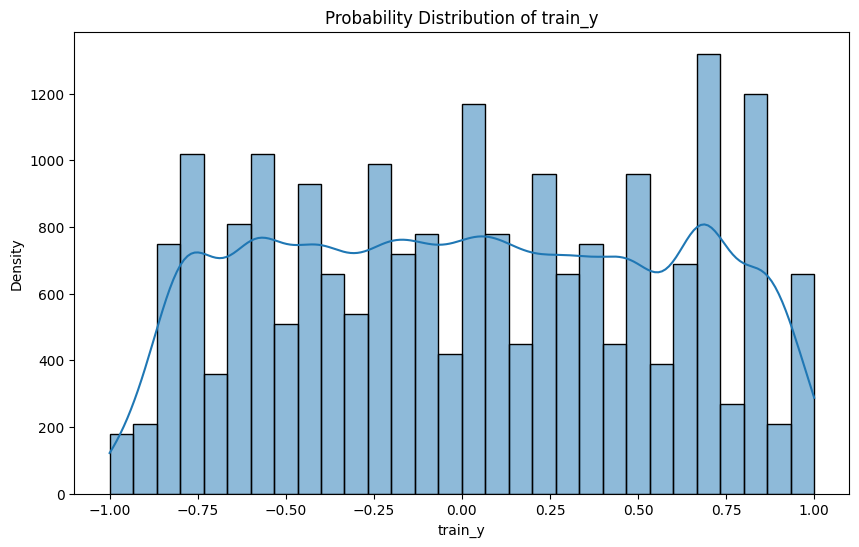

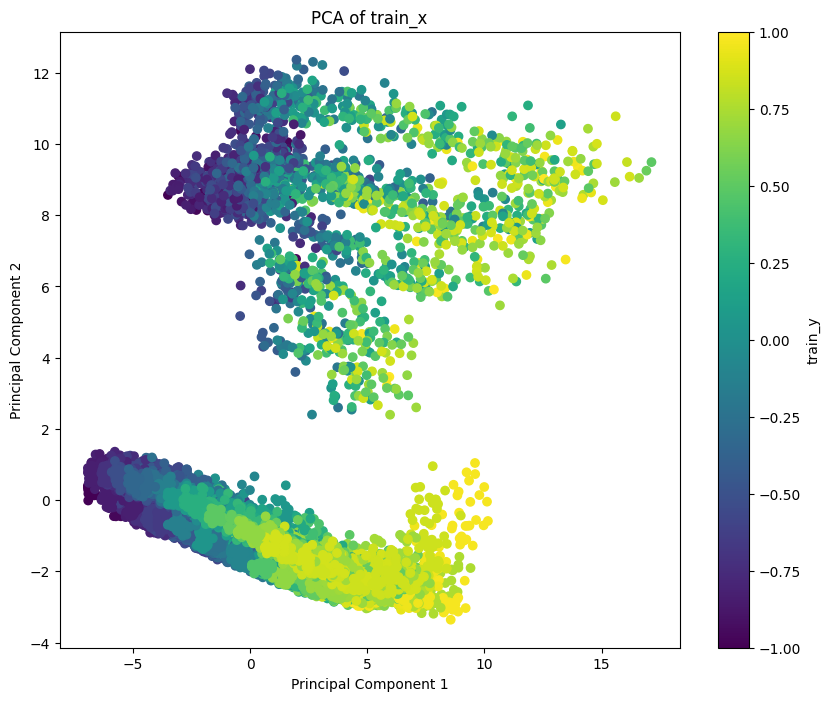

In [4]:
import matplotlib.pyplot as plt # A plotting library for Python.
import seaborn as sns # A statistical data visualization library based on matplotlib.
from sklearn.decomposition import PCA # Principal Component Analysis (PCA) for dimensionality reduction.
from scipy.stats import pearsonr # Pearson correlation coefficient calculation.

# Function to export plot as an image
def save_plot_as_image(fig, filename):
    fig.savefig(filename, bbox_inches='tight')



# Probability distribution of train_y
plt.figure(figsize=(10, 6))
sns.histplot(train_y, kde=True) # kernel density estimate (KDE)
plt.title('Probability Distribution of train_y') # A histogram plot with a kernel density estimate (KDE) is created using seaborn's histplot function.
plt.xlabel('train_y')
plt.ylabel('Density')
save_plot_as_image(plt.gcf(), 'train_y_distribution.png')


# PCA plot
pca = PCA(n_components=2) # PCA is applied to the input features (train_x) to reduce their dimensionality to 2 components.
train_x_pca = pca.fit_transform(train_x)

plt.figure(figsize=(10, 8))
plt.scatter(train_x_pca[:, 0], train_x_pca[:, 1], c=train_y, cmap='viridis')
plt.title('PCA of train_x')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='train_y')
save_plot_as_image(plt.gcf(), 'pca_plot.png')

# These visualizations provide insights into the distribution of the output variable (train_y)
# and the distribution of the data after dimensionality reduction using PCA. They can help in
# understanding the data and identifying any patterns or correlations.


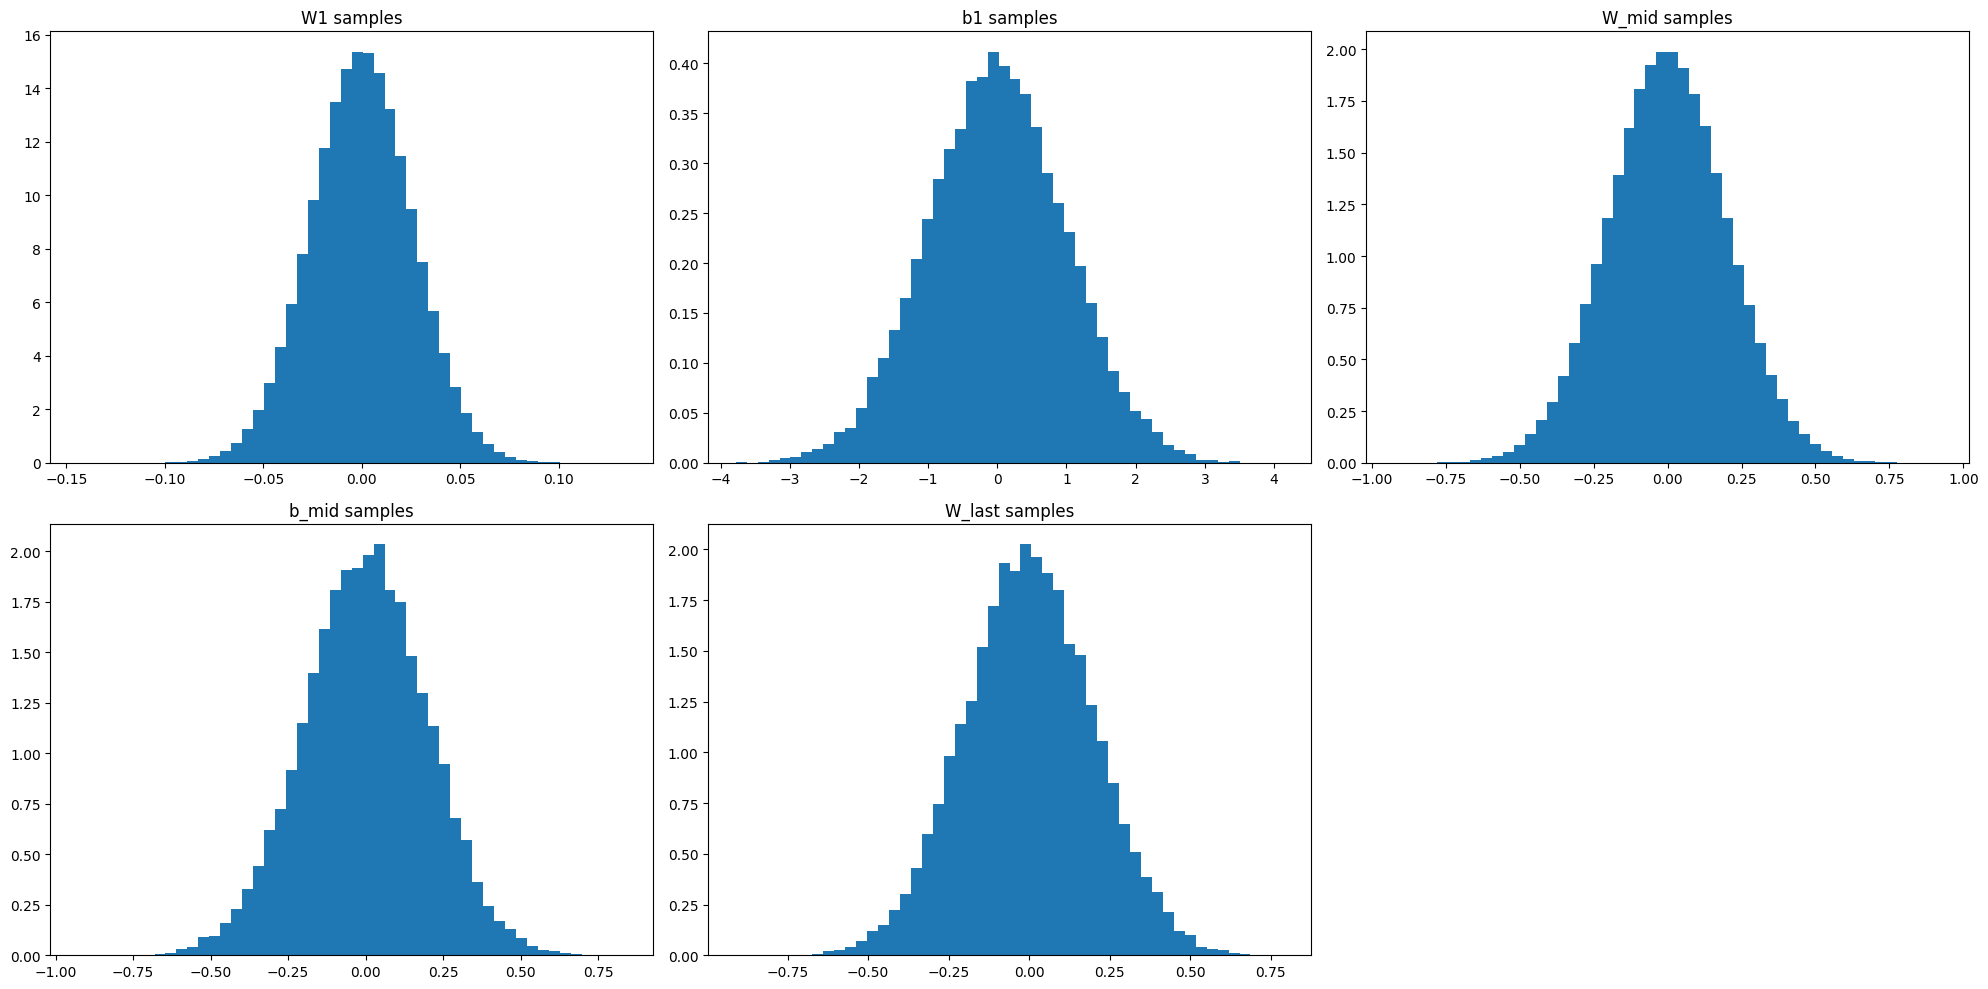

In [5]:
# Number of samples to generate
num_samples = 1000

# Generate samples for each layer
W1_samples = np.random.normal(loc=0, scale=np.sqrt(W1_var), size=(num_samples, n_dim, n_hidden)) # Samples for the weights of the first layer.
b1_samples = np.random.normal(loc=0, scale=np.sqrt(W1_var * n_dim), size=(num_samples, n_hidden)) # Samples for the biases of the first layer.
W_mid_samples = np.random.normal(loc=0, scale=np.sqrt(W_mid_var), size=(num_samples, n_hidden, n_hidden)) #  Samples for the weights of the middle layer.
b_mid_samples = np.random.normal(loc=0, scale=np.sqrt(W_mid_var), size=(num_samples, n_hidden)) # Samples for the biases of the middle layer.
W_last_samples = np.random.normal(loc=0, scale=np.sqrt(W_last_var), size=(num_samples, n_hidden, 1)) # Samples for the weights of the last layer.

import matplotlib.pyplot as plt

# Create a figure and subplots
fig = plt.figure(figsize=(20, 10))

# Plot histograms of the samples
plt.subplot(2, 3, 1)
plt.hist(W1_samples.flatten(), bins=50, density=True)
plt.title('W1 samples')

plt.subplot(2, 3, 2)
plt.hist(b1_samples.flatten(), bins=50, density=True)
plt.title('b1 samples')

plt.subplot(2, 3, 3)
plt.hist(W_mid_samples.flatten(), bins=50, density=True)
plt.title('W_mid samples')

plt.subplot(2, 3, 4)
plt.hist(b_mid_samples.flatten(), bins=50, density=True)
plt.title('b_mid samples')

plt.subplot(2, 3, 5)
plt.hist(W_last_samples.flatten(), bins=50, density=True)
plt.title('W_last samples')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as an image (e.g., PNG format)
plt.savefig('histograms.png')

# Display the figure
plt.show()



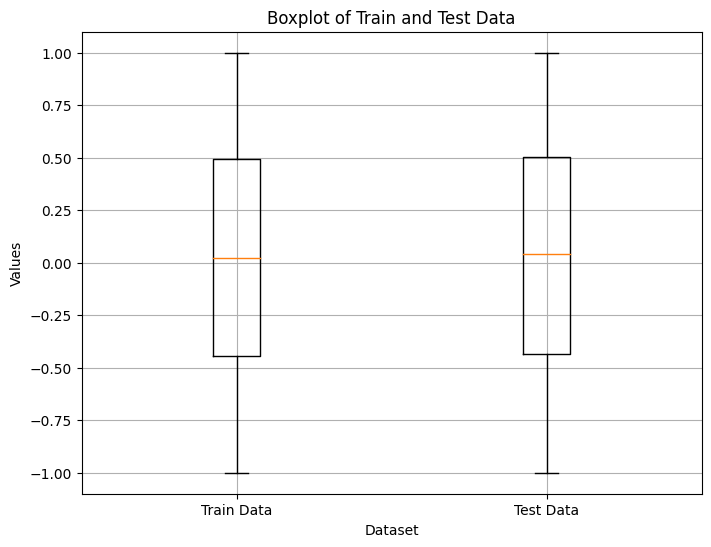

ANOVA F-Statistic: 2.05
ANOVA p-value: 0.1521


In [6]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Example data (replace with train_y and test_y from your code)
group1 = train_y  # Group 1 (train_y)
group2 = test_y   # Group 2 (test_y)

# Perform one-way ANOVA (Analysis of Variance) test
f_statistic, p_value = stats.f_oneway(group1, group2)

# Plot boxplot for visualization
plt.figure(figsize=(8, 6))
plt.boxplot([group1, group2], labels=['Train Data', 'Test Data'])
plt.title('Boxplot of Train and Test Data')
plt.xlabel('Dataset')
plt.ylabel('Values')
plt.grid(True)

# Save the plot as an image
plt.savefig('boxplot_train_test.png')
plt.show()

# Print ANOVA results
print(f"ANOVA F-Statistic: {f_statistic:.2f}")
print(f"ANOVA p-value: {p_value:.4f}")

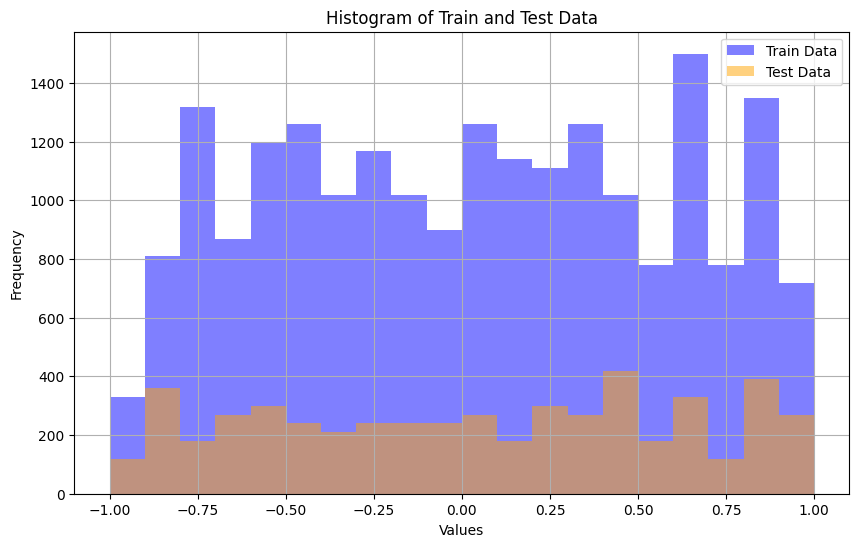

Independent Samples T-Statistic: -1.43
Independent Samples p-value: 0.1521


In [7]:
# Perform independent samples t-test
t_statistic, p_value = stats.ttest_ind(train_y, test_y)

# Plot histograms for visualization
plt.figure(figsize=(10, 6))
plt.hist(train_y, bins=20, alpha=0.5, label='Train Data', color='blue')
plt.hist(test_y, bins=20, alpha=0.5, label='Test Data', color='orange')
plt.title('Histogram of Train and Test Data')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Save the plot as an image
plt.savefig('histogram_train_test.png')
plt.show()

# Print t-test results
print(f"Independent Samples T-Statistic: {t_statistic:.2f}")
print(f"Independent Samples p-value: {p_value:.4f}")

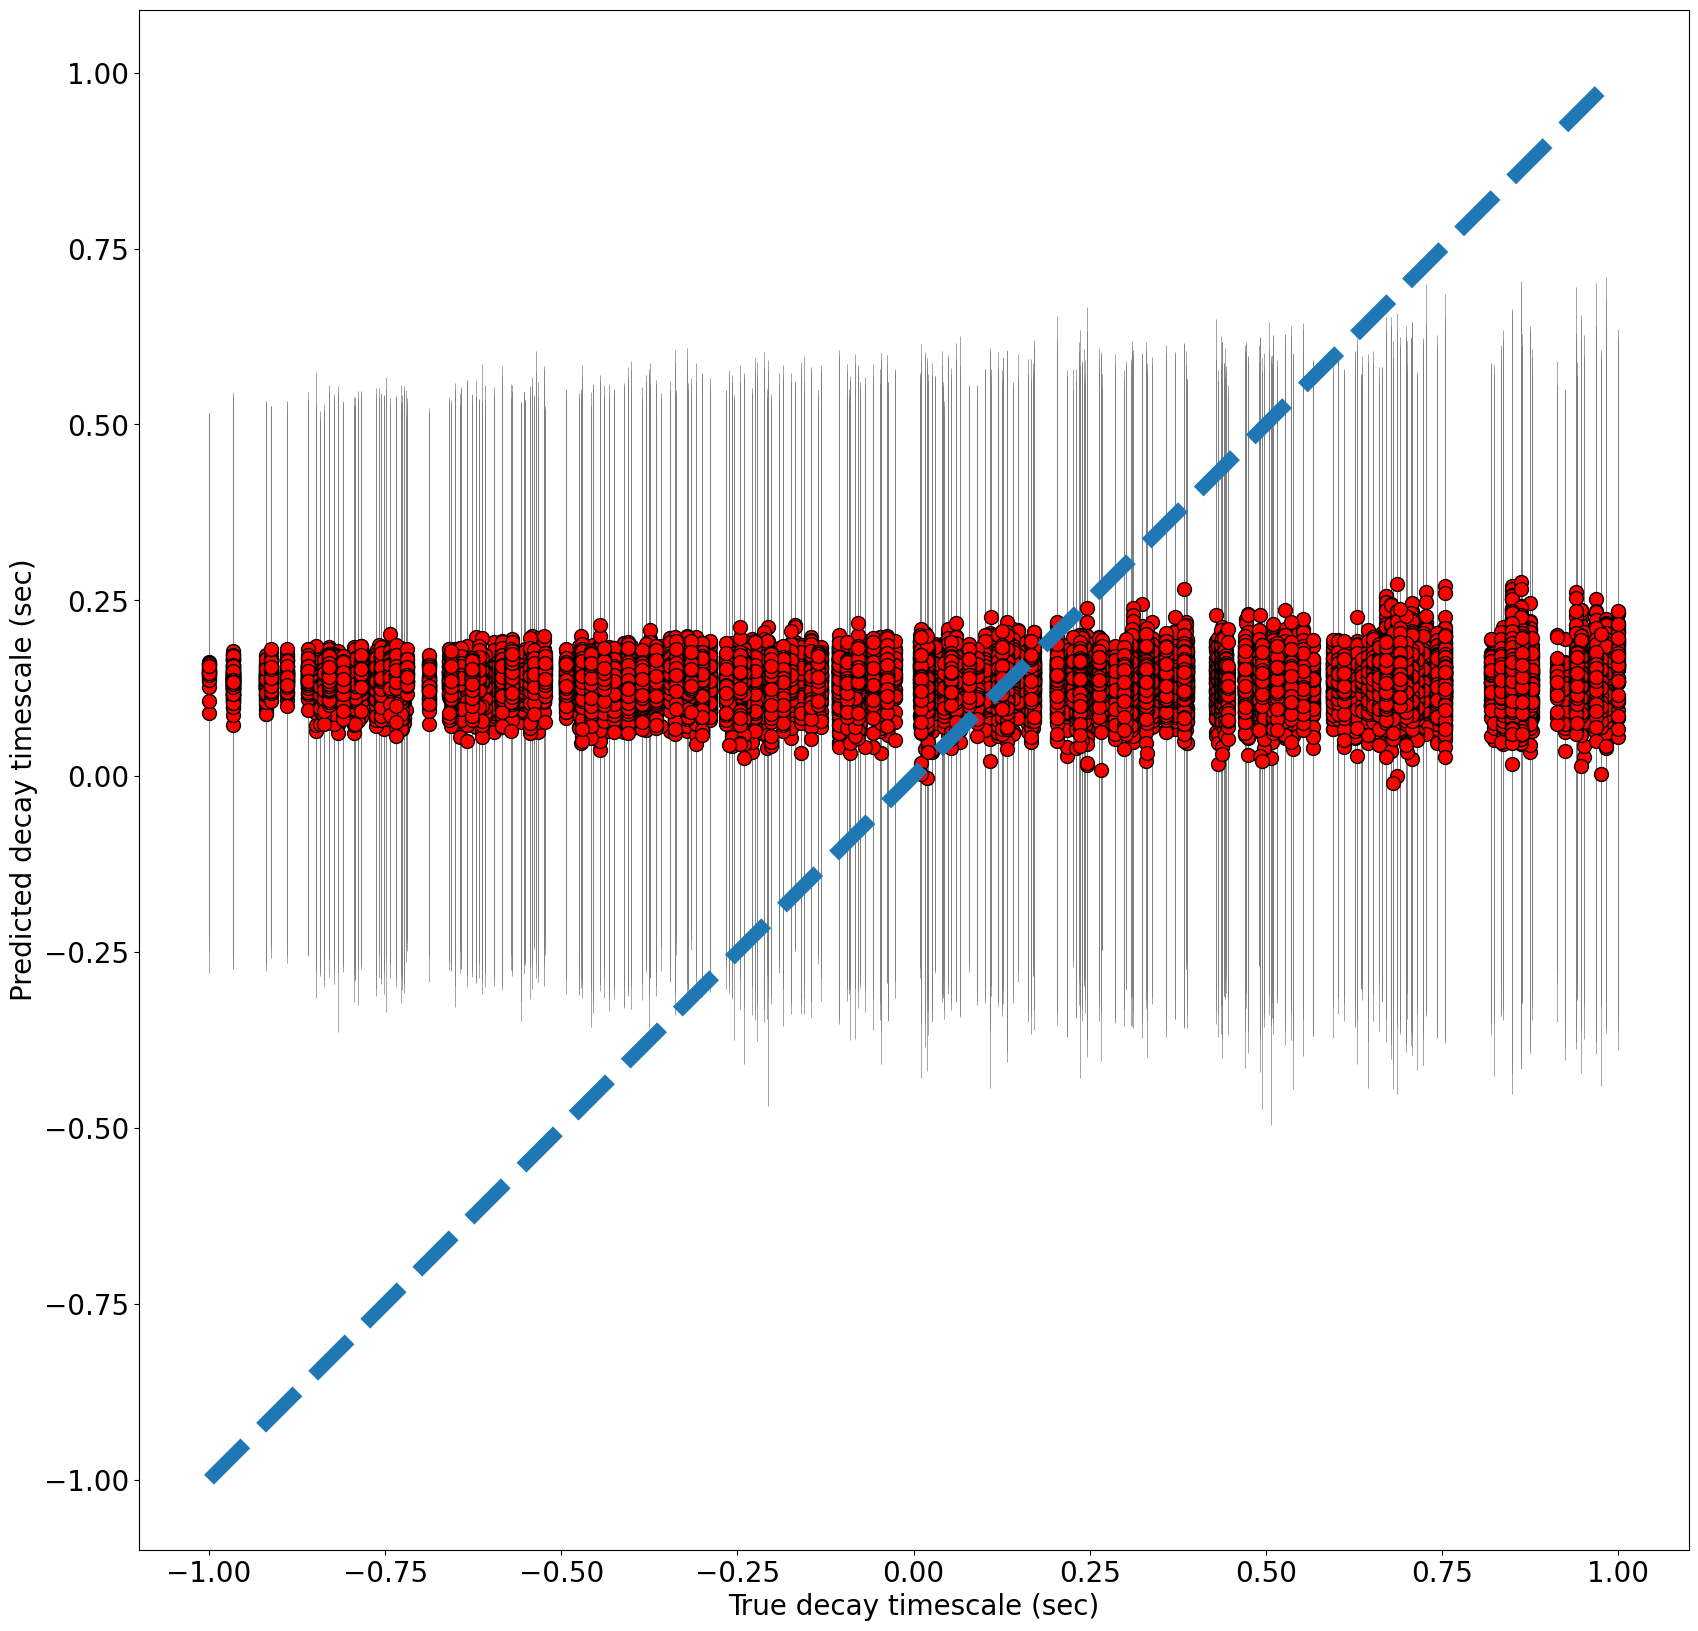

0.36746648


In [8]:
# y_preds_train: Predictions made by each neural network in the ensemble for the training data.
y_preds_train, y_preds_mu_train, y_preds_std_train = fn_predict_ensemble(NNs, train_x)

# Reshape the arrays to 1D
train_y = np.squeeze(train_y)
y_preds_mu_train = np.squeeze(y_preds_mu_train) # Mean predictions across the ensemble for the training data.  
y_preds_std_train = np.squeeze(y_preds_std_train) # Standard deviations of predictions across the ensemble for the training data.
 
# Plot predictions
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,20))
plt.errorbar(train_y, y_preds_mu_train, yerr=y_preds_std_train*1, linewidth=0.5, color='gray', ms=10, mfc='red', mec='black', fmt='o')
plt.plot(np.arange(np.min(train_y), np.max(train_y), 0.01), np.arange(np.min(train_y), np.max(train_y), 0.01), linewidth=10, linestyle='dashed', zorder=100)
plt.xlabel('True decay timescale (sec)')
plt.ylabel('Predicted decay timescale (sec)')
plt.show()

print(np.mean(y_preds_std_train))


In [9]:
# Define the number of epochs and batch size for training
epochs = 50
batch_size = 32

# Create a list to store training history for each neural network
NNs_hist_train = []

# Train each neural network in the ensemble
for model in NNs:
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model and record the training history
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1)

    # Append the training history to the list
    NNs_hist_train.append(history.history['loss'])

Epoch 1/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1215
Epoch 2/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0520
Epoch 3/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0415
Epoch 4/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0394
Epoch 5/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0375
Epoch 6/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0358
Epoch 7/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0349
Epoch 8/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0352
Epoch 9/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0346
Epoch 10/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0354
Epoch 11/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0350
Epoch 12/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0335
Epoch 13/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0327
Epoch 14/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0334
Epoch 15/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0348
Epoch 12/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0328
Epoch 13/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0317
Epoch 14/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0343
Epoch 15/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0345
Epoch 16/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0321
Epoch 17/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0306
Epoch 18/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0312
Epoch 19/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0320
Epoch 20/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0302
Epoch 21/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0309
Epoch 22/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0309
Epoch 23/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0315
Epoch 24/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0309
Epoch 25/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss:

651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0315
Epoch 22/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0321
Epoch 23/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0332
Epoch 24/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0329
Epoch 25/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0322
Epoch 26/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0364
Epoch 27/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0325
Epoch 28/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0328
Epoch 29/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0319
Epoch 30/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0318
Epoch 31/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0323
Epoch 32/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0319
Epoch 33/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0322
Epoch 34/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0323
Epoch 35/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss:

651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0326
Epoch 32/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0320
Epoch 33/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0307
Epoch 34/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0293
Epoch 35/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0310
Epoch 36/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0325
Epoch 37/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0304
Epoch 38/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0297
Epoch 39/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0310
Epoch 40/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0297
Epoch 41/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0316
Epoch 42/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0307
Epoch 43/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0300
Epoch 44/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0320
Epoch 45/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss:

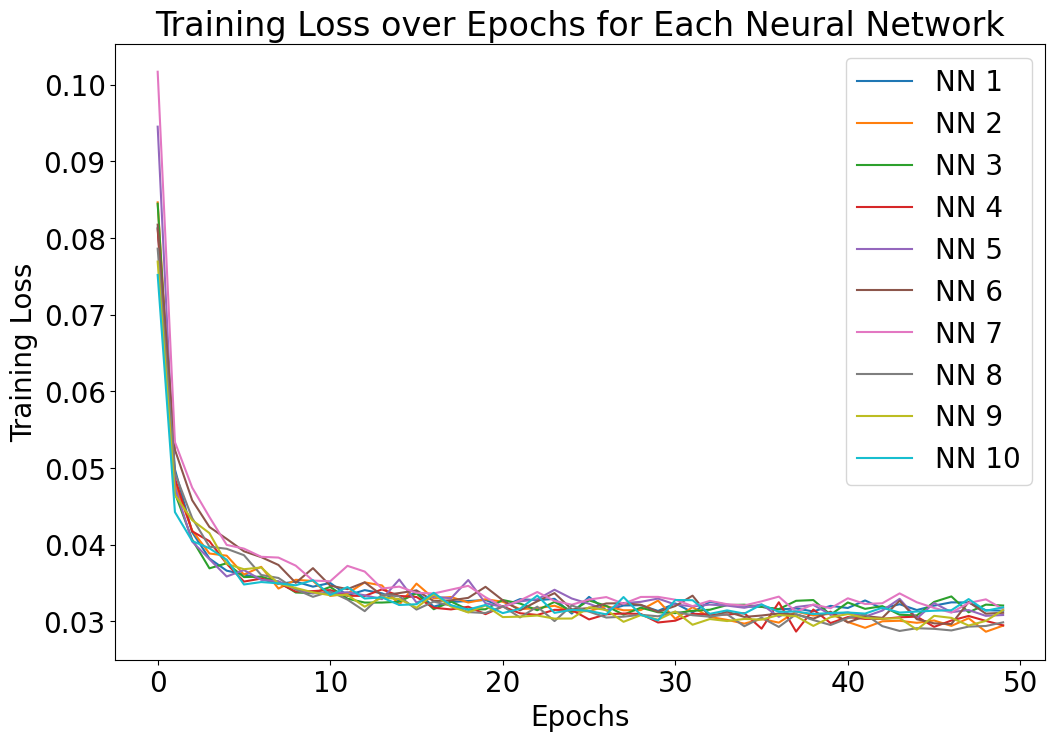

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training loss for each neural network
plt.figure(figsize=(12, 8))
for i, loss_history in enumerate(NNs_hist_train):
    plt.plot(loss_history, label=f'NN {i+1}')

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs for Each Neural Network')
plt.legend()
plt.show()
# Save the plot as an image
plt.savefig('training_loss_plot.png')



In [11]:
# run predictions
y_preds_train, y_preds_mu_train, y_preds_std_train = fn_predict_ensemble(NNs,train_x) # Running Predictions on Training Data 
y_preds_test, y_preds_mu_test, y_preds_std_test = fn_predict_ensemble(NNs,test_x) # Running Predictions on Testing Data
y_preds_std_train = np.sqrt(np.square(y_preds_std_train) + data_noise) # Adjusting Standard Deviations
y_preds_std_test = np.sqrt(np.square(y_preds_std_test) + data_noise)

In [12]:
print('Test RMSE: {}'.format(np.sqrt(np.mean(np.square(y_preds_mu_test.T - test_y)))))
print('Train RMSE: {}'.format(np.sqrt(np.mean(np.square(y_preds_mu_train.T - train_y)))))

Test RMSE: 0.1757082588430802
Train RMSE: 0.1470949595672435


In [13]:
# performing inverse scaling to revert the previously applied min-max scaling on the target variables
# (train_y and test_y) and the predictions (y_preds_mu_train

train_y = (train_y + 1)*((max_decaytime - min_decaytime)/2) + min_decaytime # Inverse Scaling for train_y and test_y:
test_y = (test_y + 1)*((max_decaytime - min_decaytime)/2) + min_decaytime
y_preds_mu_train = (y_preds_mu_train + 1)*((max_decaytime - min_decaytime)/2) + min_decaytime # Inverse Scaling for y_preds_mu_train and y_preds_mu_test:
y_preds_mu_test = (y_preds_mu_test + 1)*((max_decaytime - min_decaytime)/2) + min_decaytime
y_preds_std_train = y_preds_std_train*((max_decaytime - min_decaytime)/2) # Inverse Scaling for y_preds_std_train and y_preds_std_test:
y_preds_std_test = y_preds_std_test*((max_decaytime - min_decaytime)/2)

In [14]:
print('Test RMSE: {}'.format(np.sqrt(np.mean(np.square(np.squeeze(y_preds_mu_test) - test_y)))))
print('Train RMSE: {}'.format(np.sqrt(np.mean(np.square(np.squeeze(y_preds_mu_train) - train_y)))))

Test RMSE: 0.035020660481746325
Train RMSE: 0.029317702374354996


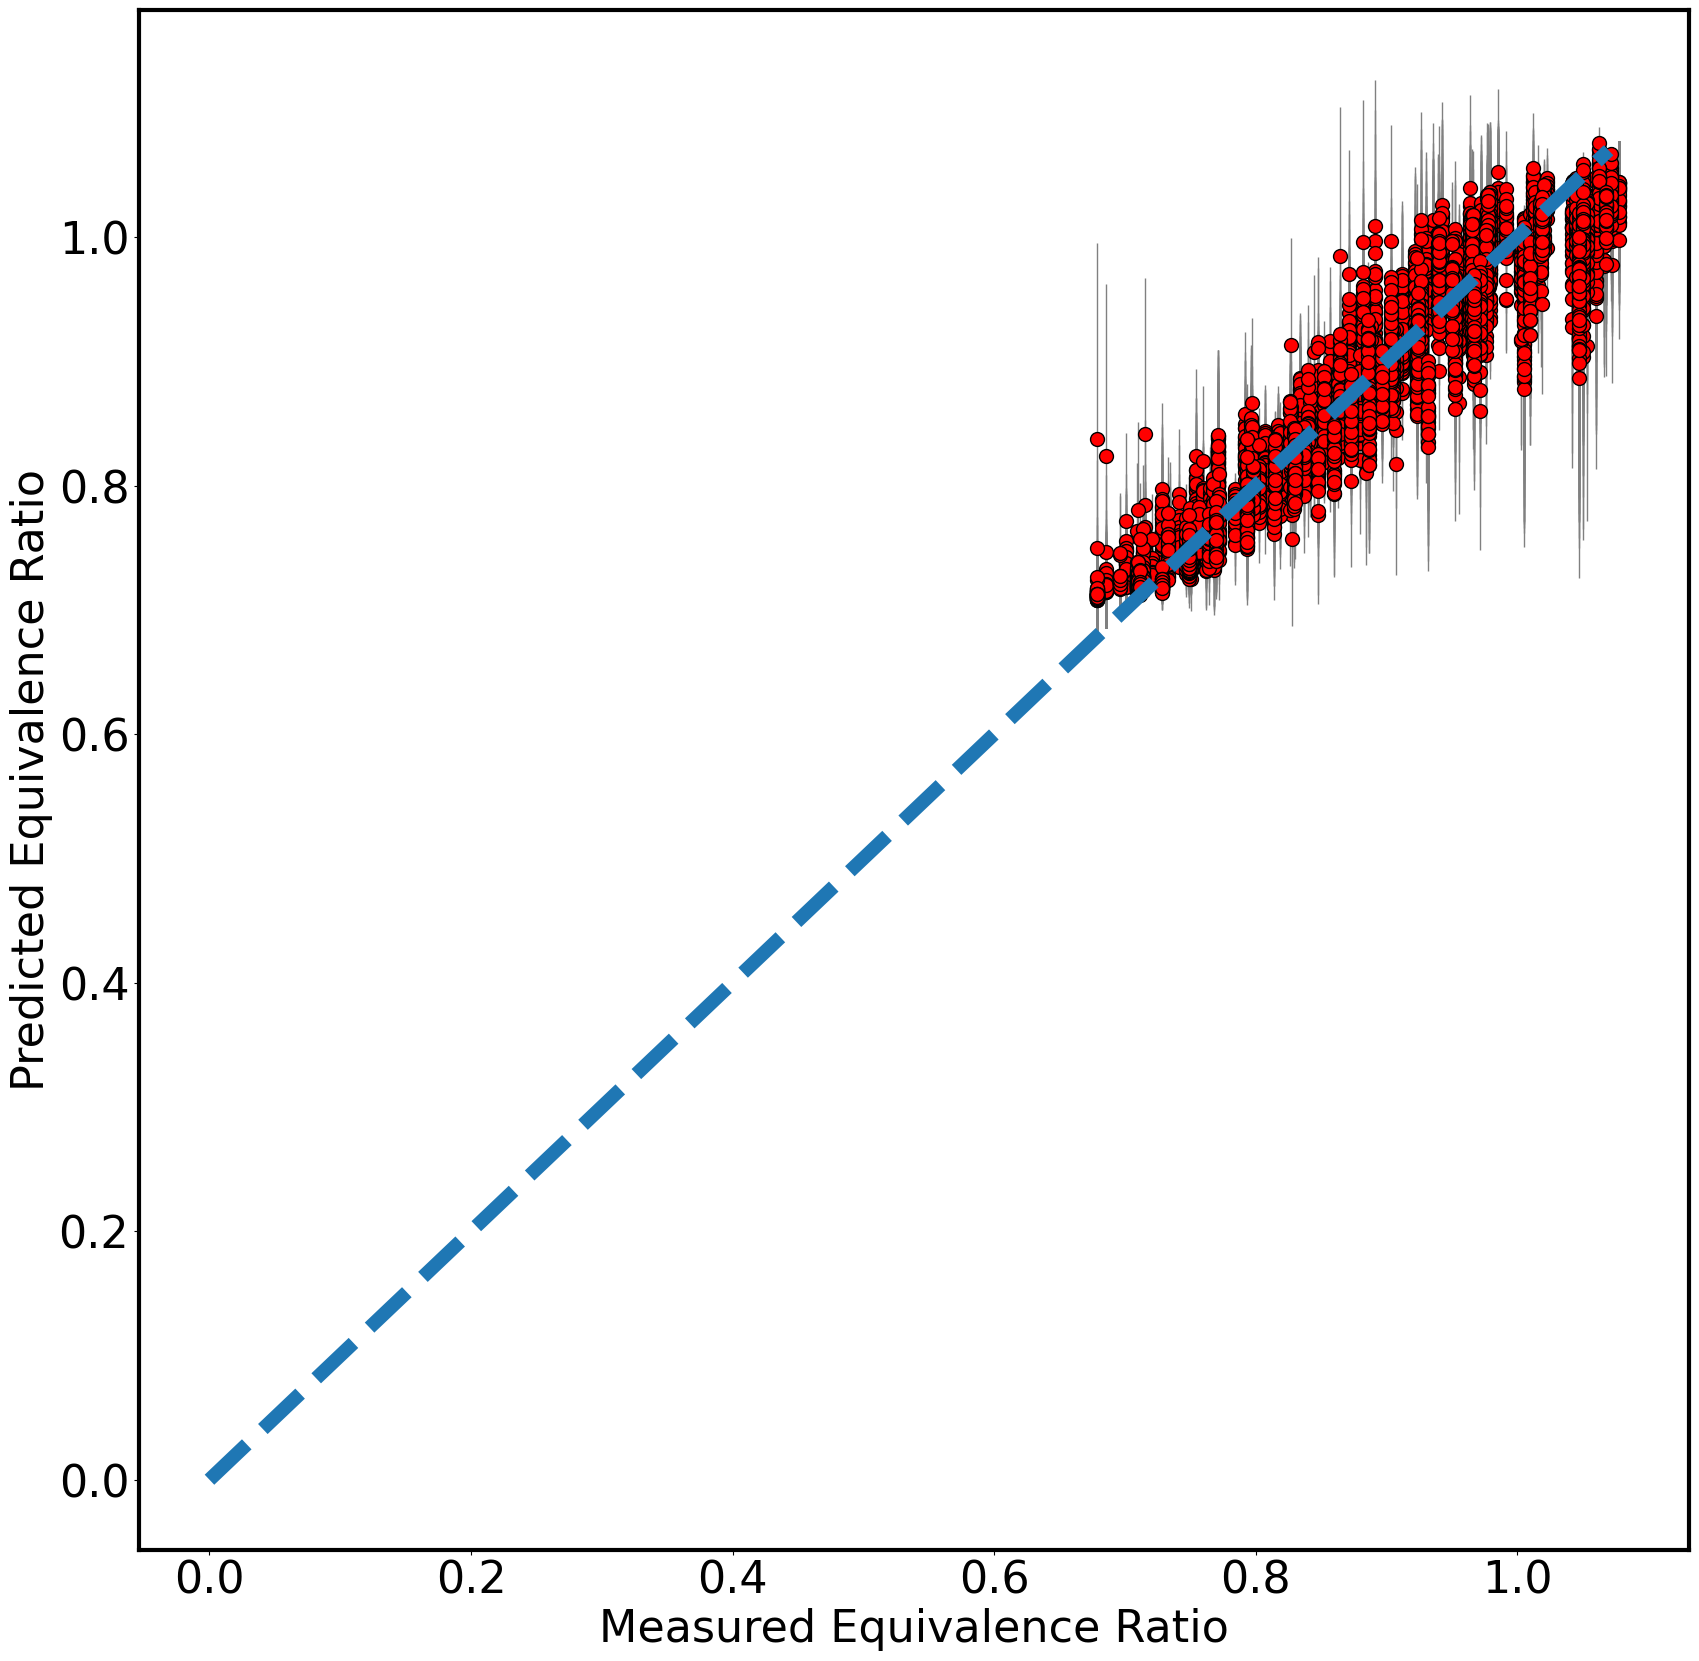

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming test_y contains measured equivalence ratios (2D array)
# Assuming y_preds_mu_test contains predicted equivalence ratios (2D array)
# Assuming y_preds_std_test contains standard deviation of predictions (2D array)

# Flatten the arrays to 1D for plotting
test_y = test_y.flatten()
y_preds_mu_test = y_preds_mu_test.flatten()
y_preds_std_test = y_preds_std_test.flatten()

# Calculate absolute errors for error bars
y_err = np.abs(test_y - y_preds_mu_test)

# Set plot parameters
plt.rcParams.update({'font.size': 32})
plt.rcParams['axes.linewidth'] = 3

# Create a new figure with specified size
plt.figure(figsize=(20, 20))

# Plot measured vs predicted equivalence ratio with error bars
plt.errorbar(test_y, y_preds_mu_test, yerr=y_err, linewidth=1.0, color='gray', ms=10, mfc='red', mec='black', fmt='o')

# Plot the ideal y = x line
plt.plot(np.arange(0, np.max(test_y), 0.01), np.arange(0, np.max(test_y), 0.01), linewidth=10, linestyle='dashed', zorder=100)

# Set labels for x-axis and y-axis
plt.xlabel('Measured Equivalence Ratio')
plt.ylabel('Predicted Equivalence Ratio')

# Draw the plot
plt.draw()

# Save the plot as an image (PNG format)
plt.savefig('testperformance.png', format='png')

# Display the plot
plt.show()

In [16]:
%matplotlib inline
import tensorflow as tf
from math import pi
import keras
import gdown
from keras import backend as K
from keras.layers import Dense
from keras.models import Sequential, Model
from keras import regularizers  # Import regularizers module
import matplotlib.pyplot as plt
import numpy as np
import os.path
from scipy.io import loadmat

# Define PReLU activation function
class PReLU(tf.keras.layers.Layer):
    def __init__(self, alpha_initializer='zeros', **kwargs):
        super(PReLU, self).__init__(**kwargs)
        self.alpha_initializer = tf.keras.initializers.get(alpha_initializer)

    def build(self, input_shape):
        self.alpha = self.add_weight(shape=(input_shape[-1],),
                                      initializer=self.alpha_initializer,
                                      name='alpha',
                                      trainable=True)
        super(PReLU, self).build(input_shape)

    def call(self, inputs):
        pos = tf.nn.relu(inputs)
        neg = -self.alpha * tf.nn.relu(-inputs)
        return pos + neg

output_q = 'decay' #output_q can take the following values -- 'decay', 'eq', 'power'
train_x = loadmat('All_Data.mat')['input_data_train']
test_x = loadmat('All_Data.mat')['input_data_test']
train_y = np.squeeze(loadmat('All_Data.mat')[output_q + '_train'])
test_y = np.squeeze(loadmat('All_Data.mat')[output_q + '_test'])

# Do minmax scaling
min_x = train_x.min(0)
max_x = train_x.max(0)
train_x = 2*(train_x - min_x)/(max_x - min_x) - 1
test_x = 2*(test_x - min_x)/(max_x - min_x) - 1

# Do minmax scaling
min_decaytime = train_y.min(0)
max_decaytime = train_y.max(0)
train_y = 2*(train_y - min_decaytime)/(max_decaytime - min_decaytime) - 1
test_y = 2*(test_y - min_decaytime)/(max_decaytime - min_decaytime) - 1

# NN options
n_ensemble = 10 # TUNE! no. NNs in ensemble
reg = 'anc'      # type of regularisation to use - anc (anchoring) reg (regularised) free (unconstrained)
n_hidden = 25    # TUNE! no. hidden units in NN
activation_in = 'relu' #tanh relu sigmoid
data_noise = (0.03/((max_decaytime - min_decaytime)/2))**2 # TUNE! estimated noise variance

n_data = train_x.shape[0]
print(n_data)
n_dim = train_x.shape[-1]
print(n_dim)

# Variance of priors
W1_var = 1.0/n_dim        # TUNE! 1st layer weights and biases
W_mid_var = 1.0/n_hidden  # 2nd layer weights and biases
W_last_var = 1.0/n_hidden # 3rd layer weights

# NN object
def fn_make_NN(reg='anc', activation_in='relu'):
    # get initialisations, and regularisation values
    W1_lambda = data_noise/W1_var
    W1_anc = np.random.normal(loc=0, scale=np.sqrt(W1_var), size=[n_dim, n_hidden])
    W1_init = np.random.normal(loc=0, scale=np.sqrt(W1_var), size=[n_dim, n_hidden])

    b1_var = W1_var * n_dim
    b1_lambda =  data_noise / b1_var
    b1_anc = np.random.normal(loc=0, scale=np.sqrt(b1_var), size=[n_hidden])
    b1_init = np.random.normal(loc=0, scale=np.sqrt(b1_var), size=[n_hidden])

    W_mid_lambda = data_noise / W_mid_var
    W_mid_anc = np.random.normal(loc=0, scale=np.sqrt(W_mid_var), size=[n_hidden, n_hidden])
    W_mid_init = np.random.normal(loc=0, scale=np.sqrt(W_mid_var), size=[n_hidden, n_hidden])

    b_mid_var = W_mid_var
    b_mid_lambda =  data_noise / b_mid_var
    b_mid_anc = np.random.normal(loc=0, scale=np.sqrt(b_mid_var), size=[n_hidden])
    b_mid_init = np.random.normal(loc=0, scale=np.sqrt(b_mid_var), size=[n_hidden])

    W_last_lambda = data_noise / W_last_var
    W_last_anc = np.random.normal(loc=0, scale=np.sqrt(W_last_var), size=[n_hidden, 1])
    W_last_init = np.random.normal(loc=0, scale=np.sqrt(W_last_var), size=[n_hidden, 1])

    def custom_reg_W1(W1_lambda, n_data):
        if reg == 'reg':
            return regularizers.l2(W1_lambda / n_data)
        elif reg == 'free':
            return None
        elif reg == 'anc':
            return regularizers.l2(W1_lambda / n_data)

    def custom_reg_b1(b1_lambda, n_data):
        if reg == 'reg':
            return regularizers.l2(b1_lambda / n_data)
        elif reg == 'free':
            return None
        elif reg == 'anc':
            return regularizers.l2(b1_lambda / n_data)

    def custom_reg_W_mid(W_mid_lambda, n_data):
        if reg == 'reg':
            return regularizers.l2(W_mid_lambda / n_data)
        elif reg == 'free':
            return None
        elif reg == 'anc':
            return regularizers.l2(W_mid_lambda / n_data)

    def custom_reg_b_mid(b_mid_lambda, n_data):
        if reg == 'reg':
            return regularizers.l2(b_mid_lambda / n_data)
        elif reg == 'free':
            return None
        elif reg == 'anc':
            return regularizers.l2(b_mid_lambda / n_data)

    def custom_reg_W_last(W_last_lambda, n_data):
        if reg == 'reg':
            return regularizers.l2(W_last_lambda / n_data)
        elif reg == 'free':
            return None
        elif reg == 'anc':
            return regularizers.l2(W_last_lambda / n_data)

    model = Sequential()  # Initialize the model

    # Modify your model creation to pass the required parameters
    model.add(Dense(n_hidden, activation=activation_in, input_shape=(n_dim,),
                    kernel_initializer=keras.initializers.Constant(value=W1_init),
                    bias_initializer=keras.initializers.Constant(value=b1_init),
                    kernel_regularizer=custom_reg_W1(W1_lambda, n_data),
                    bias_regularizer=custom_reg_b1(b1_lambda, n_data)))

    model.add(Dense(n_hidden, activation=activation_in,
                    kernel_initializer=keras.initializers.Constant(value=W_mid_init),
                    bias_initializer=keras.initializers.Constant(value=b_mid_init),
                    kernel_regularizer=custom_reg_W_mid(W_mid_lambda, n_data),
                    bias_regularizer=custom_reg_b_mid(b_mid_lambda, n_data)))

    model.add(Dense(1, activation='linear', use_bias=False,
                    kernel_initializer=keras.initializers.Constant(value=W_last_init),
                    kernel_regularizer=custom_reg_W_last(W_last_lambda, n_data)))

    return model


def fn_predict_ensemble(NNs, x_test):
    ''' fn to predict given a list of NNs (an ensemble)'''
    y_preds = []
    for m in range(len(NNs)):
        y_preds.append(NNs[m].predict(x_test, verbose=0))
    y_preds = np.array(y_preds)

    y_preds_mu = np.mean(y_preds, axis=0)
    y_preds_std = np.std(y_preds, axis=0)

    return y_preds, y_preds_mu, y_preds_std

# Create the NNs
NNs = []
for m in range(n_ensemble):
    NNs.append(fn_make_NN(reg=reg, activation_in=activation_in))

print(NNs[-1].summary())

20820
1501


C:\python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                     │ (None, 25)                  │          37,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 25)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,225 (149.32 KB)

 Trainable params: 38,225 (149.32 KB)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
# Define the number of epochs and batch size for training
epochs = 50
batch_size = 32

# Create a list to store training history for each neural network
NNs_hist_train = []

# Train each neural network in the ensemble
for model in NNs:
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model and record the training history
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1)

    # Append the training history to the list
    NNs_hist_train.append(history.history['loss'])

Epoch 1/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0807
Epoch 2/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0340
Epoch 3/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0253
Epoch 4/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0211
Epoch 5/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0186
Epoch 6/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0192
Epoch 7/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0172
Epoch 8/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0163
Epoch 9/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0172
Epoch 10/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0178
Epoch 11/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0159
Epoch 12/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0168
Epoch 13/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0154
Epoch 14/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0155
Epoch 15/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0183
Epoch 12/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step - loss: 0.0180
Epoch 13/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step - loss: 0.0184
Epoch 14/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step - loss: 0.0178
Epoch 15/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step - loss: 0.0247
Epoch 16/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0219
Epoch 17/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - loss: 0.0201
Epoch 18/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - loss: 0.0184
Epoch 19/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - loss: 0.0182
Epoch 20/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - loss: 0.0179
Epoch 21/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - loss: 0.0179
Epoch 22/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - loss: 0.0187
Epoch 23/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - loss: 0.0180
Epoch 24/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - loss: 0.0178
Epoch 25/50
651/651 ━━━━━━━━━━━━━━━━

651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0160
Epoch 21/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0153
Epoch 22/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0151
Epoch 23/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0152
Epoch 24/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0148
Epoch 25/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0143
Epoch 26/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0154
Epoch 27/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0154
Epoch 28/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0147
Epoch 29/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0147
Epoch 30/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0143
Epoch 31/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0146
Epoch 32/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0140
Epoch 33/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0155
Epoch 34/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss:

651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0146 
Epoch 31/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step - loss: 0.0147
Epoch 32/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - loss: 0.0154
Epoch 33/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step - loss: 0.0153
Epoch 34/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step - loss: 0.0148
Epoch 35/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step - loss: 0.0156
Epoch 36/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step - loss: 0.0144
Epoch 37/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - loss: 0.0152
Epoch 38/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - loss: 0.0153
Epoch 39/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step - loss: 0.0147
Epoch 40/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - loss: 0.0142
Epoch 41/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - loss: 0.0169
Epoch 42/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - loss: 0.0144
Epoch 43/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - loss: 0.0145
Epoch 44/50
651/651 ━━━━━━━━━━━━━

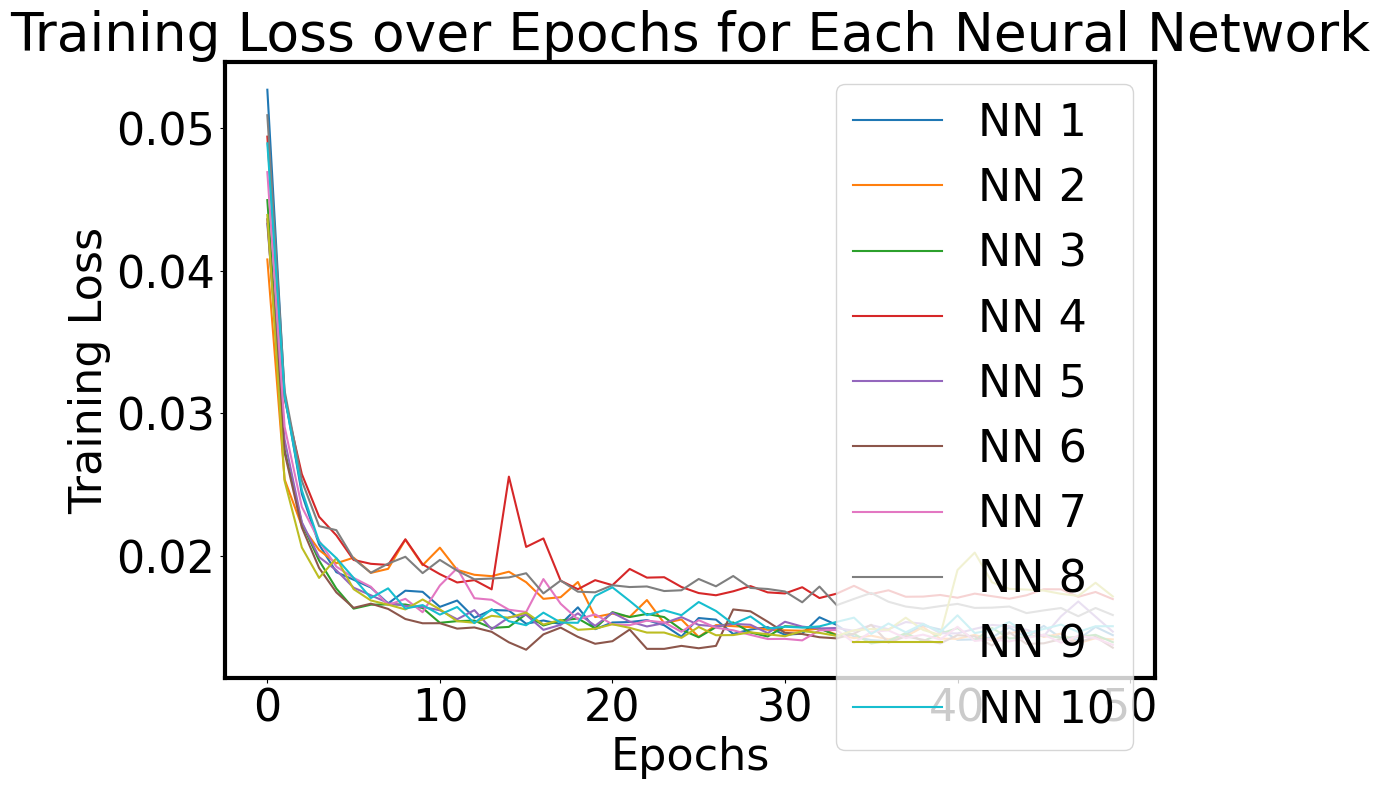

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training loss for each neural network
plt.figure(figsize=(12, 8))
for i, loss_history in enumerate(NNs_hist_train):
    plt.plot(loss_history, label=f'NN {i+1}')

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs for Each Neural Network')
plt.legend()
plt.show()
# Save the plot as an image
plt.savefig('training_loss_plot.png')

In [19]:
# run predictions
y_preds_train, y_preds_mu_train, y_preds_std_train = fn_predict_ensemble(NNs,train_x)
y_preds_test, y_preds_mu_test, y_preds_std_test = fn_predict_ensemble(NNs,test_x)
y_preds_std_train = np.sqrt(np.square(y_preds_std_train) + data_noise)
y_preds_std_test = np.sqrt(np.square(y_preds_std_test) + data_noise)

In [20]:
print('Test RMSE: {}'.format(np.sqrt(np.mean(np.square(y_preds_mu_test.T - test_y)))))
print('Train RMSE: {}'.format(np.sqrt(np.mean(np.square(y_preds_mu_train.T - train_y)))))

Test RMSE: 0.11856427123701002
Train RMSE: 0.09973896629388745


In [21]:
# Undoing Min-Max Scaling for train_y and test_y:
train_y = (train_y + 1)*((max_decaytime - min_decaytime)/2) + min_decaytime
test_y = (test_y + 1)*((max_decaytime - min_decaytime)/2) + min_decaytime
y_preds_mu_train = (y_preds_mu_train + 1)*((max_decaytime - min_decaytime)/2) + min_decaytime
y_preds_mu_test = (y_preds_mu_test + 1)*((max_decaytime - min_decaytime)/2) + min_decaytime

# Adjusting Standard Deviation for Predictions:
y_preds_std_train = y_preds_std_train*((max_decaytime - min_decaytime)/2)
y_preds_std_test = y_preds_std_test*((max_decaytime - min_decaytime)/2)

In [22]:
print('Test RMSE: {}'.format(np.sqrt(np.mean(np.square(np.squeeze(y_preds_mu_test) - test_y)))))
print('Train RMSE: {}'.format(np.sqrt(np.mean(np.square(np.squeeze(y_preds_mu_train) - train_y)))))

Test RMSE: 0.028214659350714863
Train RMSE: 0.023734814332634996


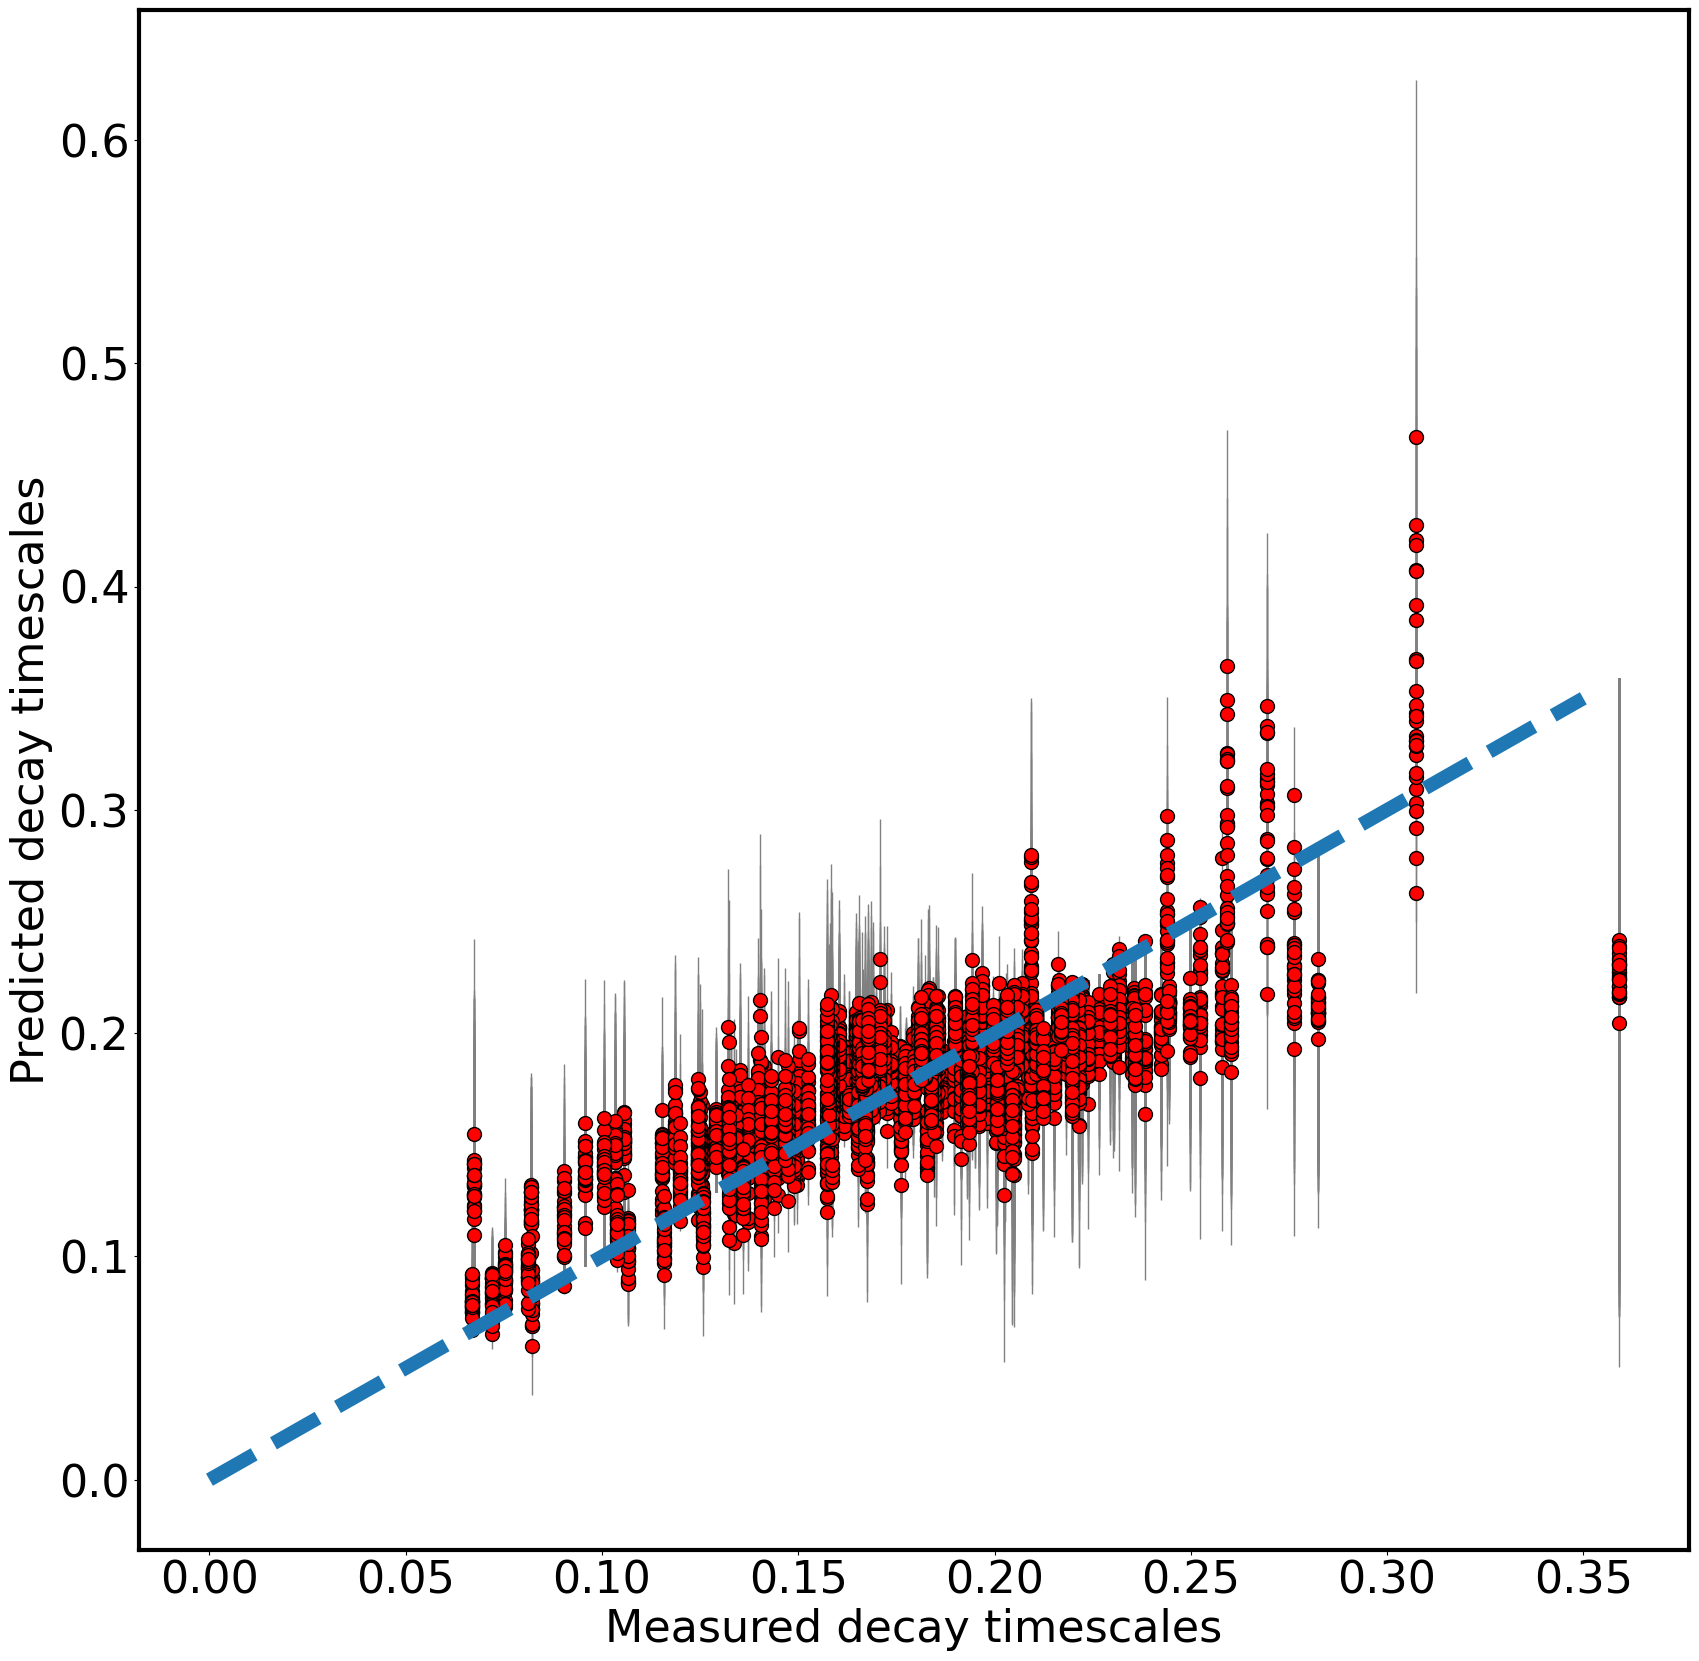

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming test_y contains measured equivalence ratios (2D array)
# Assuming y_preds_mu_test contains predicted equivalence ratios (2D array)
# Assuming y_preds_std_test contains standard deviation of predictions (2D array)

# Flatten the arrays to 1D for plotting
test_y = test_y.flatten()
y_preds_mu_test = y_preds_mu_test.flatten()
y_preds_std_test = y_preds_std_test.flatten()

# Calculate absolute errors for error bars
y_err = np.abs(test_y - y_preds_mu_test)

# Set plot parameters
plt.rcParams.update({'font.size': 32})
plt.rcParams['axes.linewidth'] = 3

# Create a new figure with specified size
plt.figure(figsize=(20, 20))

# Plot measured vs predicted equivalence ratio with error bars
plt.errorbar(test_y, y_preds_mu_test, yerr=y_err, linewidth=1.0, color='gray', ms=10, mfc='red', mec='black', fmt='o')

# Plot the ideal y = x line
plt.plot(np.arange(0, np.max(test_y), 0.01), np.arange(0, np.max(test_y), 0.01), linewidth=10, linestyle='dashed', zorder=100)

# Set labels for x-axis and y-axis
plt.xlabel('Measured decay timescales')
plt.ylabel('Predicted decay timescales')

# Draw the plot
plt.draw()

# Save the plot as an image (PNG format)
plt.savefig('testperformance.png', format='png')

# Display the plot
plt.show()

In [24]:
%matplotlib inline
import tensorflow as tf
from math import pi
import keras
import gdown
from keras import backend as K
from keras.layers import Dense
from keras.models import Sequential, Model
from keras import regularizers  # Import regularizers module
import matplotlib.pyplot as plt
import numpy as np
import os.path
from scipy.io import loadmat

# Define PReLU activation function
class PReLU(tf.keras.layers.Layer):
    def __init__(self, alpha_initializer='zeros', **kwargs):
        super(PReLU, self).__init__(**kwargs)
        self.alpha_initializer = tf.keras.initializers.get(alpha_initializer)

    def build(self, input_shape):
        self.alpha = self.add_weight(shape=(input_shape[-1],),
                                      initializer=self.alpha_initializer,
                                      name='alpha',
                                      trainable=True)
        super(PReLU, self).build(input_shape)

    def call(self, inputs):
        pos = tf.nn.relu(inputs)
        neg = -self.alpha * tf.nn.relu(-inputs)
        return pos + neg

output_q = 'power' #output_q can take the following values -- 'decay', 'eq', 'power'
train_x = loadmat('All_Data.mat')['input_data_train']
test_x = loadmat('All_Data.mat')['input_data_test']
train_y = np.squeeze(loadmat('All_Data.mat')[output_q + '_train'])
test_y = np.squeeze(loadmat('All_Data.mat')[output_q + '_test'])

# Do minmax scaling
min_x = train_x.min(0)
max_x = train_x.max(0)
train_x = 2*(train_x - min_x)/(max_x - min_x) - 1
test_x = 2*(test_x - min_x)/(max_x - min_x) - 1

# Do minmax scaling
min_decaytime = train_y.min(0)
max_decaytime = train_y.max(0)
train_y = 2*(train_y - min_decaytime)/(max_decaytime - min_decaytime) - 1
test_y = 2*(test_y - min_decaytime)/(max_decaytime - min_decaytime) - 1

# NN options
n_ensemble = 10 # TUNE! no. NNs in ensemble
reg = 'anc'      # type of regularisation to use - anc (anchoring) reg (regularised) free (unconstrained)
n_hidden = 25    # TUNE! no. hidden units in NN
activation_in = 'relu' #tanh relu sigmoid
data_noise = (0.03/((max_decaytime - min_decaytime)/2))**2 # TUNE! estimated noise variance

n_data = train_x.shape[0]
print(n_data)
n_dim = train_x.shape[-1]
print(n_dim)

# Variance of priors
W1_var = 1.0/n_dim        # TUNE! 1st layer weights and biases
W_mid_var = 1.0/n_hidden  # 2nd layer weights and biases
W_last_var = 1.0/n_hidden # 3rd layer weights

# NN object
def fn_make_NN(reg='anc', activation_in='relu'):
    # get initialisations, and regularisation values
    W1_lambda = data_noise/W1_var
    W1_anc = np.random.normal(loc=0, scale=np.sqrt(W1_var), size=[n_dim, n_hidden])
    W1_init = np.random.normal(loc=0, scale=np.sqrt(W1_var), size=[n_dim, n_hidden])

    b1_var = W1_var * n_dim
    b1_lambda =  data_noise / b1_var
    b1_anc = np.random.normal(loc=0, scale=np.sqrt(b1_var), size=[n_hidden])
    b1_init = np.random.normal(loc=0, scale=np.sqrt(b1_var), size=[n_hidden])

    W_mid_lambda = data_noise / W_mid_var
    W_mid_anc = np.random.normal(loc=0, scale=np.sqrt(W_mid_var), size=[n_hidden, n_hidden])
    W_mid_init = np.random.normal(loc=0, scale=np.sqrt(W_mid_var), size=[n_hidden, n_hidden])

    b_mid_var = W_mid_var
    b_mid_lambda =  data_noise / b_mid_var
    b_mid_anc = np.random.normal(loc=0, scale=np.sqrt(b_mid_var), size=[n_hidden])
    b_mid_init = np.random.normal(loc=0, scale=np.sqrt(b_mid_var), size=[n_hidden])

    W_last_lambda = data_noise / W_last_var
    W_last_anc = np.random.normal(loc=0, scale=np.sqrt(W_last_var), size=[n_hidden, 1])
    W_last_init = np.random.normal(loc=0, scale=np.sqrt(W_last_var), size=[n_hidden, 1])

    def custom_reg_W1(W1_lambda, n_data):
        if reg == 'reg':
            return regularizers.l2(W1_lambda / n_data)
        elif reg == 'free':
            return None
        elif reg == 'anc':
            return regularizers.l2(W1_lambda / n_data)

    def custom_reg_b1(b1_lambda, n_data):
        if reg == 'reg':
            return regularizers.l2(b1_lambda / n_data)
        elif reg == 'free':
            return None
        elif reg == 'anc':
            return regularizers.l2(b1_lambda / n_data)

    def custom_reg_W_mid(W_mid_lambda, n_data):
        if reg == 'reg':
            return regularizers.l2(W_mid_lambda / n_data)
        elif reg == 'free':
            return None
        elif reg == 'anc':
            return regularizers.l2(W_mid_lambda / n_data)

    def custom_reg_b_mid(b_mid_lambda, n_data):
        if reg == 'reg':
            return regularizers.l2(b_mid_lambda / n_data)
        elif reg == 'free':
            return None
        elif reg == 'anc':
            return regularizers.l2(b_mid_lambda / n_data)

    def custom_reg_W_last(W_last_lambda, n_data):
        if reg == 'reg':
            return regularizers.l2(W_last_lambda / n_data)
        elif reg == 'free':
            return None
        elif reg == 'anc':
            return regularizers.l2(W_last_lambda / n_data)

    model = Sequential()  # Initialize the model

    # Modify your model creation to pass the required parameters
    model.add(Dense(n_hidden, activation=activation_in, input_shape=(n_dim,),
                    kernel_initializer=keras.initializers.Constant(value=W1_init),
                    bias_initializer=keras.initializers.Constant(value=b1_init),
                    kernel_regularizer=custom_reg_W1(W1_lambda, n_data),
                    bias_regularizer=custom_reg_b1(b1_lambda, n_data)))

    model.add(Dense(n_hidden, activation=activation_in,
                    kernel_initializer=keras.initializers.Constant(value=W_mid_init),
                    bias_initializer=keras.initializers.Constant(value=b_mid_init),
                    kernel_regularizer=custom_reg_W_mid(W_mid_lambda, n_data),
                    bias_regularizer=custom_reg_b_mid(b_mid_lambda, n_data)))

    model.add(Dense(1, activation='linear', use_bias=False,
                    kernel_initializer=keras.initializers.Constant(value=W_last_init),
                    kernel_regularizer=custom_reg_W_last(W_last_lambda, n_data)))

    return model


def fn_predict_ensemble(NNs, x_test):
    ''' fn to predict given a list of NNs (an ensemble)'''
    y_preds = []
    for m in range(len(NNs)):
        y_preds.append(NNs[m].predict(x_test, verbose=0))
    y_preds = np.array(y_preds)

    y_preds_mu = np.mean(y_preds, axis=0)
    y_preds_std = np.std(y_preds, axis=0)

    return y_preds, y_preds_mu, y_preds_std

# Create the NNs
NNs = []
for m in range(n_ensemble):
    NNs.append(fn_make_NN(reg=reg, activation_in=activation_in))

print(NNs[-1].summary())

20820
1501


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_87 (Dense)                     │ (None, 25)                  │          37,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 25)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,225 (149.32 KB)

 Trainable params: 38,225 (149.32 KB)

 Non-trainable params: 0 (0.00 B)

None


In [25]:
# Define the number of epochs and batch size for training
epochs = 50
batch_size = 32

# Create a list to store training history for each neural network
NNs_hist_train = []

# Train each neural network in the ensemble
for model in NNs:
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model and record the training history
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1)

    # Append the training history to the list
    NNs_hist_train.append(history.history['loss'])

Epoch 1/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0798
Epoch 2/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0223
Epoch 3/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0183
Epoch 4/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0147
Epoch 5/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0148
Epoch 6/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0126
Epoch 7/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0105
Epoch 8/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0101
Epoch 9/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - loss: 0.0097
Epoch 10/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093
Epoch 11/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0098  
Epoch 12/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095
Epoch 13/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089
Epoch 14/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0083
Epoch 15/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step 

651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step - loss: 0.0114
Epoch 11/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 883us/step - loss: 0.0104
Epoch 12/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step - loss: 0.0100
Epoch 13/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - loss: 0.0093
Epoch 14/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 891us/step - loss: 0.0101
Epoch 15/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step - loss: 0.0085
Epoch 16/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - loss: 0.0077
Epoch 17/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - loss: 0.0074
Epoch 18/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step - loss: 0.0087
Epoch 19/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 910us/step - loss: 0.0089
Epoch 20/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - loss: 0.0085
Epoch 21/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - loss: 0.0073
Epoch 22/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - loss: 0.0071
Epoch 23/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - loss: 0.0079
Epoch 24/50
651/651 ━━━━━━━━━━━━

651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073
Epoch 41/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0083
Epoch 42/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073
Epoch 43/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0076
Epoch 44/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077
Epoch 45/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0082
Epoch 46/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072
Epoch 47/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0081
Epoch 48/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0075
Epoch 49/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0067
Epoch 50/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0067
Epoch 1/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0689
Epoch 2/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0255
Epoch 3/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0196
Epoch 4/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0

651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072
Epoch 1/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0738
Epoch 2/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0231
Epoch 3/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0190
Epoch 4/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0148
Epoch 5/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0141
Epoch 6/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0131
Epoch 7/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0120
Epoch 8/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0111
Epoch 9/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0112
Epoch 10/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0106
Epoch 11/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0099
Epoch 12/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096
Epoch 13/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092
Epoch 14/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094
E

In [26]:
# run predictions
y_preds_train, y_preds_mu_train, y_preds_std_train = fn_predict_ensemble(NNs,train_x)
y_preds_test, y_preds_mu_test, y_preds_std_test = fn_predict_ensemble(NNs,test_x)
y_preds_std_train = np.sqrt(np.square(y_preds_std_train) + data_noise)
y_preds_std_test = np.sqrt(np.square(y_preds_std_test) + data_noise)

In [27]:
print('Test RMSE: {}'.format(np.sqrt(np.mean(np.square(y_preds_mu_test.T - test_y)))))
print('Train RMSE: {}'.format(np.sqrt(np.mean(np.square(y_preds_mu_train.T - train_y)))))

Test RMSE: 0.07397238139801501
Train RMSE: 0.061482545944663645


In [28]:
train_y = (train_y + 1)*((max_decaytime - min_decaytime)/2) + min_decaytime
test_y = (test_y + 1)*((max_decaytime - min_decaytime)/2) + min_decaytime
y_preds_mu_train = (y_preds_mu_train + 1)*((max_decaytime - min_decaytime)/2) + min_decaytime
y_preds_mu_test = (y_preds_mu_test + 1)*((max_decaytime - min_decaytime)/2) + min_decaytime
y_preds_std_train = y_preds_std_train*((max_decaytime - min_decaytime)/2)
y_preds_std_test = y_preds_std_test*((max_decaytime - min_decaytime)/2)
print('Test RMSE: {}'.format(np.sqrt(np.mean(np.square(np.squeeze(y_preds_mu_test) - test_y)))))
print('Train RMSE: {}'.format(np.sqrt(np.mean(np.square(np.squeeze(y_preds_mu_train) - train_y)))))

Test RMSE: 0.02936111651487158
Train RMSE: 0.02440365158873594


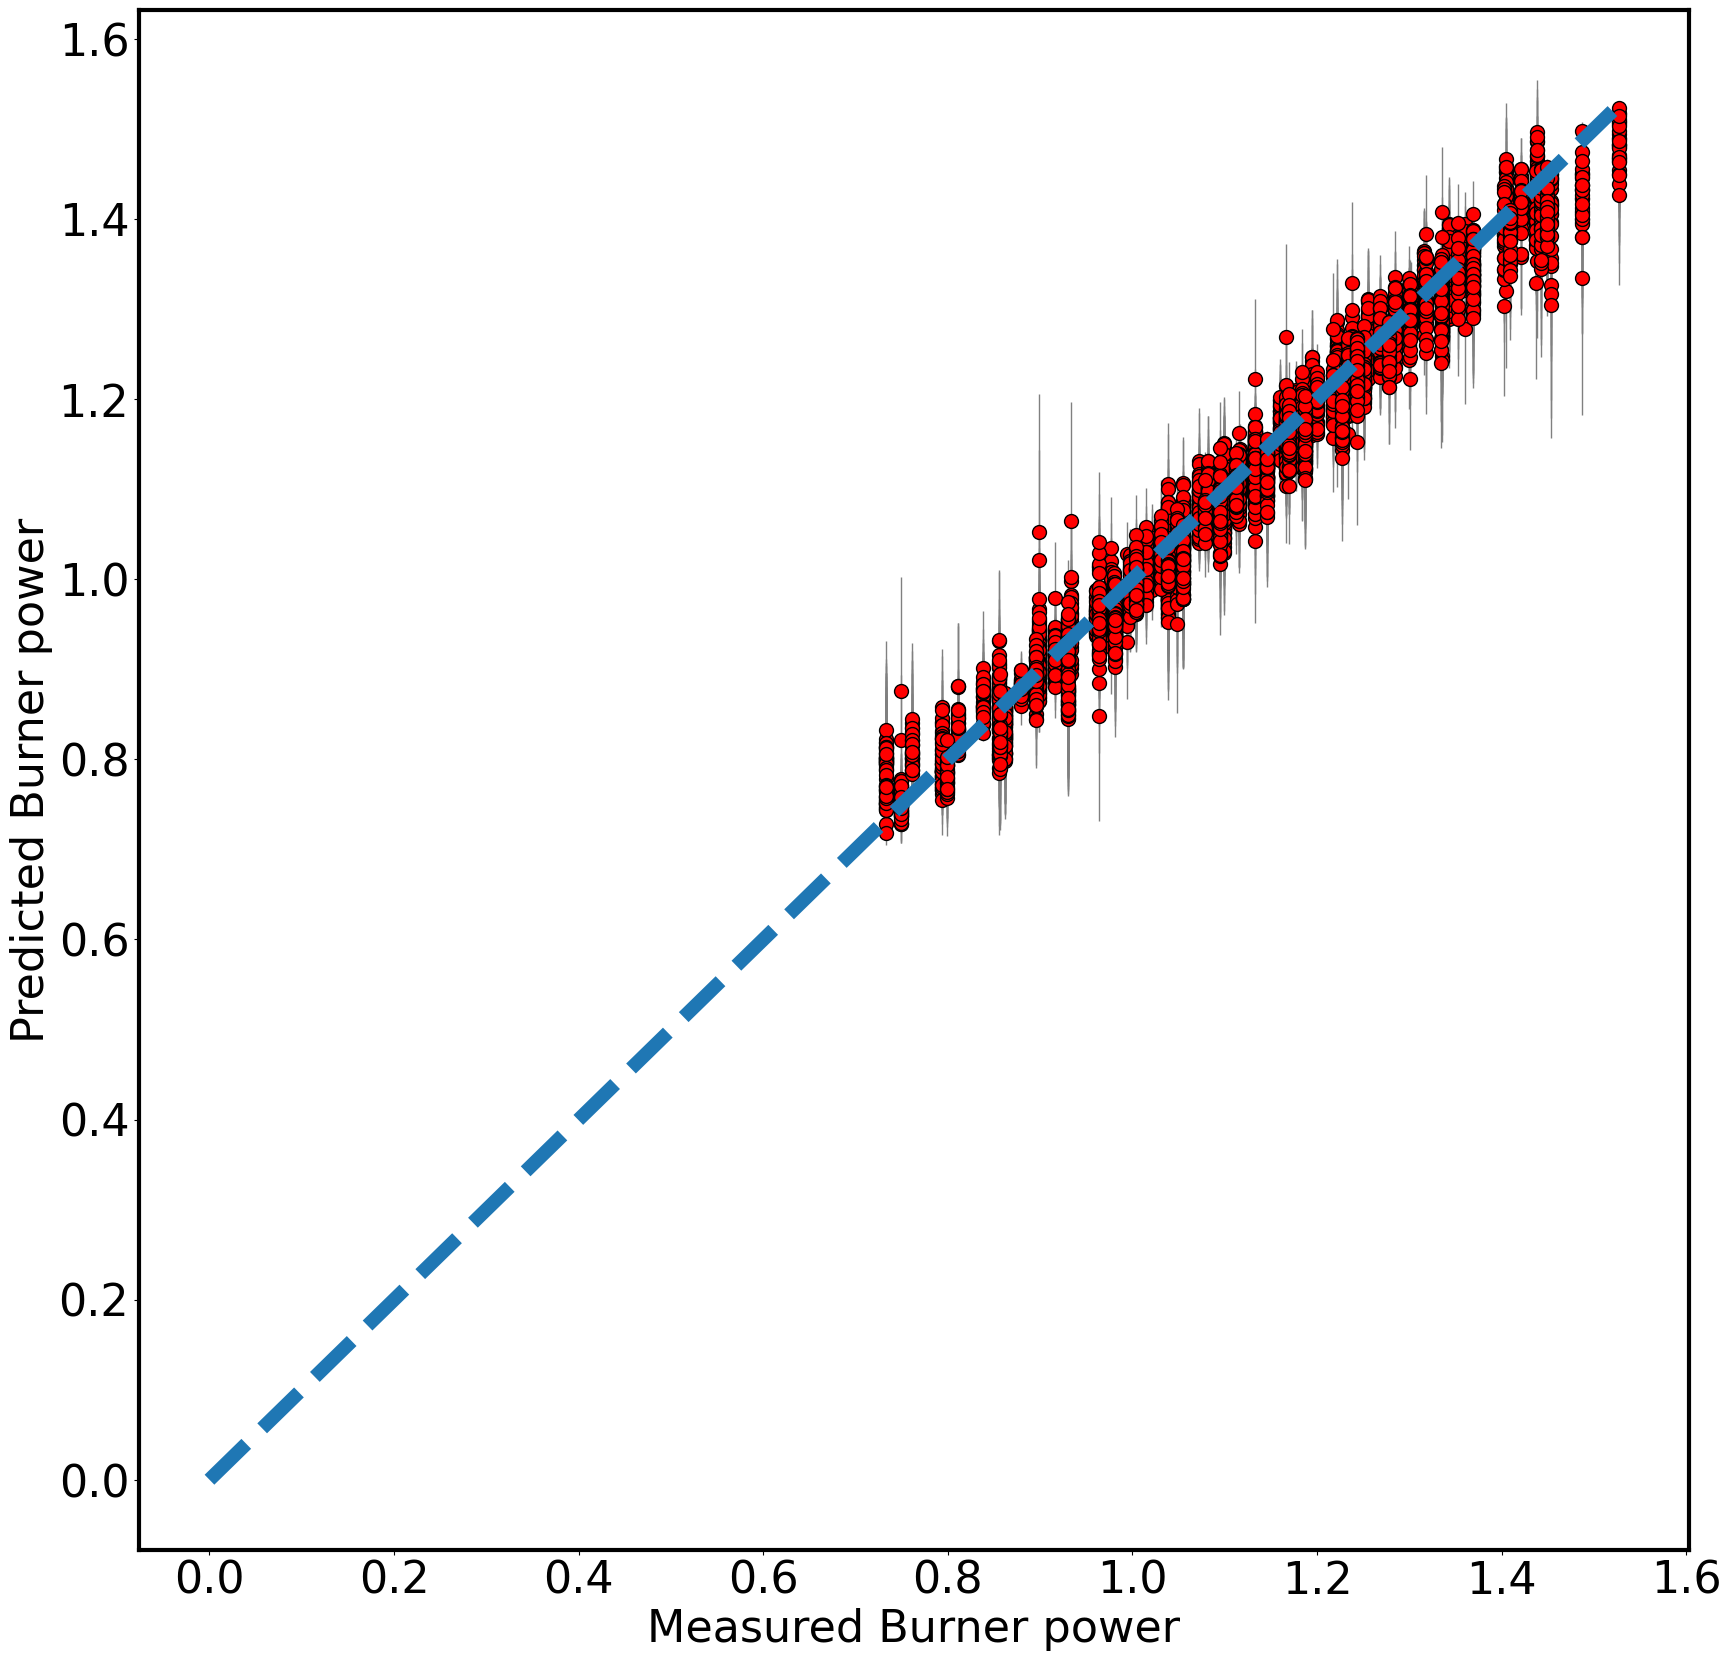

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming test_y contains measured equivalence ratios (2D array)
# Assuming y_preds_mu_test contains predicted equivalence ratios (2D array)
# Assuming y_preds_std_test contains standard deviation of predictions (2D array)

# Flatten the arrays to 1D for plotting
test_y = test_y.flatten()
y_preds_mu_test = y_preds_mu_test.flatten()
y_preds_std_test = y_preds_std_test.flatten()

# Calculate absolute errors for error bars
y_err = np.abs(test_y - y_preds_mu_test)

# Set plot parameters
plt.rcParams.update({'font.size': 32})
plt.rcParams['axes.linewidth'] = 3

# Create a new figure with specified size
plt.figure(figsize=(20, 20))

# Plot measured vs predicted equivalence ratio with error bars
plt.errorbar(test_y, y_preds_mu_test, yerr=y_err, linewidth=1.0, color='gray', ms=10, mfc='red', mec='black', fmt='o')

# Plot the ideal y = x line
plt.plot(np.arange(0, np.max(test_y), 0.01), np.arange(0, np.max(test_y), 0.01), linewidth=10, linestyle='dashed', zorder=100)

# Set labels for x-axis and y-axis
plt.xlabel('Measured Burner power')
plt.ylabel('Predicted Burner power')

# Draw the plot
plt.draw()

# Save the plot as an image (PNG format)
plt.savefig('testperformance1.png', format='png')

# Display the plot
plt.show()
